In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
pp = dict(surface='white', hemi='both')

In [2]:
info = get_info(kind='biosemi128')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.5s remaining:    2.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


# Simulate

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 2004.93it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 2/2 [00:00<00:00, 38.56it/s]

Using control points [0.         0.         0.37471426]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


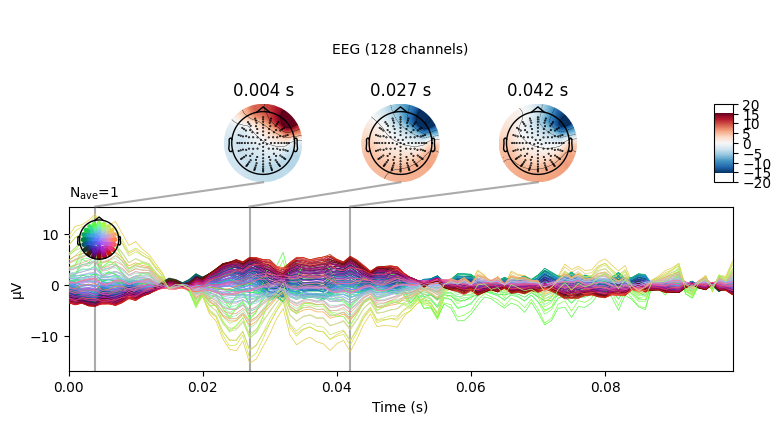

In [6]:
settings = dict(number_of_sources=(1, 15), extents=(1, 25), duration_of_trial=0.1, target_snr=1e99)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

stc.data /= abs(stc.data).max()
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

# Solve

Using control points [0.         0.         0.37251918]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


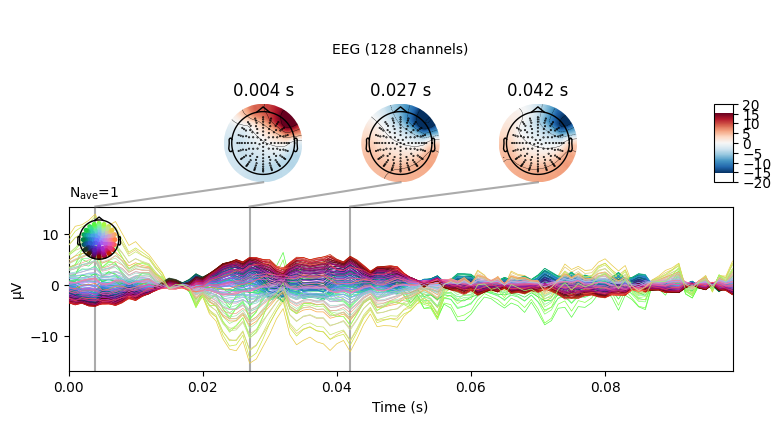

Using control points [0.         0.         0.25603893]
Using control points [0.        0.        0.2558973]


In [7]:
from invert import Solver
solver = Solver("Champagne")
solver.make_inverse_operator(fwd, evoked, alpha="auto")
stc_ = solver.apply_inverse_operator(evoked)
evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info)

stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_.plot_joint()

# Big Loop

In [12]:
from invert import Solver
# from invert.config import all_solvers
from invert.evaluate import nmse, corr, eval_mean_localization_error, eval_auc
from invert.adapters import contextualize_bd
import pickle as pkl


all_solvers = ["Champagne", "SSMP", "SubSMP", "MNE", "dSPM", 
               "LORETA", "sLORETA", "eLORETA", "LAURA", 
               "S-MAP", "Bayesian Beamformer", "LORETA", "MVAB", "L1L2"]
settings = dict(number_of_sources=(1, 15), extents=(1, 25), duration_of_trial=0.1, target_snr=1e99)

errors_corr = {sname: [] for sname in all_solvers}
errors_mle = {sname: [] for sname in all_solvers}
errors_auc = {sname: [] for sname in all_solvers}

# solvers = dict()
n_samples = 3
sim = Simulation(fwd, info, settings).simulate(n_samples)
for i in range(n_samples):
    print(i)
    
    stc = sim.source_data[i]
    evoked = sim.eeg_data[i].average()

    for solver_name in all_solvers:
        print(solver_name)
        solver = Solver(solver=solver_name)
        if (not solver_name in solvers):
            solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha="auto")
        try:
            stc_hat = solvers[solver_name].apply_inverse_operator(evoked)
        except:
            print("problem")
            stc_hat = stc.copy()
            stc_hat.data *= 0
        # stc_hat.plot(**pp, brain_kwargs=dict(title=solver.name))
        error_corr = np.mean(corr(stc.data, stc_hat.data))
        try:
            error_mle = eval_mean_localization_error(stc.data[:, 0], stc_hat.data[:, 0], pos)
        except:
            error_mle = np.nan
        error_auc = eval_auc(stc.data[:, 0], stc_hat.data[:, 0], pos)

        errors_corr[solver_name].append( error_corr )
        errors_mle[solver_name].append( error_mle )
        errors_auc[solver_name].append( error_auc )
        # print(error_corr, error_mle, error_auc)
    
# print("Saving errors")
# fn = "errors.pkl"
# with open(fn, 'wb') as f:
#     pkl.dump(errors, f)

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 3/3 [00:00<00:00, 3005.95it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 3/3 [00:00<00:00, 45.58it/s]


0
Champagne
problem
SSMP


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


SubSMP
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Bayesian Beamformer
LORETA
MVAB
L1L2
1
Champagne
problem
SSMP


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


SubSMP
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Bayesian Beamformer
LORETA
MVAB
L1L2
2
Champagne
problem
SSMP


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


SubSMP
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Bayesian Beamformer
LORETA
MVAB
L1L2


In [ ]:
# import pickle as pkl
# fn = "errors.pkl"
# with open(fn, 'rb') as f:
#     errors = pkl.load(f)

# Plot

In [21]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=0.8)

df = pd.DataFrame(errors_corr)
df = pd.DataFrame(errors_mle)
df = pd.DataFrame(errors_auc)

sorted_index = df.median().sort_values().index
df = df[sorted_index]
display(df.describe())
plt.figure()
sns.boxplot(data=df)
plt.title("Correlation with ground truth")


# df_mean_var = pd.concat([df.mean(), df.std()], axis=1)
# df_mean_var = df_mean_var.rename(columns={0: "Median", 1: "Variance"})
# df_mean_var["MedVar"] = df_mean_var["Median"] / df_mean_var["Variance"]
# df_mean_var["Method"] = df_mean_var.index
# display(df_mean_var)

# plt.figure()
# sns.scatterplot(x="Median", y="Variance", hue="Method", size="MedVar", data=df_mean_var)
# plt.xlabel("Median")
# plt.ylabel("Variance")


,LORETA,SSMP,MVAB,SubSMP,LAURA,S-MAP,eLORETA,MNE,sLORETA,dSPM,Bayesian Beamformer,L1L2
count,3.000000,3.00000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.349213,0.49750,0.656644,0.690590,0.796748,0.777269,0.864757,0.836065,0.837303,0.851690,0.942396,0.928333
std,0.028626,0.00433,0.267921,0.123206,0.078311,0.075458,0.046381,0.070641,0.067494,0.051879,0.051105,0.070648
min,0.318750,0.49250,0.488750,0.590313,0.735556,0.705000,0.820938,0.755000,0.759687,0.791875,0.902500,0.858750
25%,0.336042,0.49625,0.502153,0.621823,0.752622,0.738125,0.840469,0.811875,0.814844,0.835312,0.913594,0.892500
50%,0.353333,0.50000,0.515556,0.653333,0.769687,0.771250,0.860000,0.868750,0.870000,0.878750,0.924687,0.926250
75%,0.364444,0.50000,0.740590,0.740729,0.827344,0.813403,0.886667,0.876597,0.876111,0.881597,0.962344,0.963125
max,0.375556,0.50000,0.965625,0.828125,0.885000,0.855556,0.913333,0.884444,0.882222,0.884444,1.000000,1.000000


Text(0.5, 1.0, 'Correlation with ground truth')

In [ ]:
settings = dict(number_of_sources=3, extents=(25, 35), duration_of_trial=0.025, target_snr=99999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

In [ ]:
# from invert.solvers.empirical_bayes import SolverChampagne
# from invert.solvers.esinet import SolverFullyConnected
# solver_fc = SolverFullyConnected().make_inverse_operator(fwd, evoked)
# solver_ch = SolverChampagne().make_inverse_operator(fwd, evoked)
from invert.evaluate import nmse, corr

stc_hat = solver_ch.apply_inverse_operator(evoked)
stc_hat.plot(**pp)
# brain.add_text(0.1, 0.9, "Champagne", 'title',
#                font_size=14)
error_ch = np.mean(corr(abs(stc.data), abs(stc_hat.data)))

stc_hat = solver_fc.apply_inverse_operator(evoked)
stc_hat.plot(**pp)
# brain.add_text(0.1, 0.9, "Fully-Connected", 'title',
#                font_size=14)
error_fc = np.mean(corr(abs(stc.data), abs(stc_hat.data)))

print(f"Champ: {error_ch}\nFC: {error_fc}")